---
title: "Sexism Detection"
author:
  - Francesco Baiocchi
  - Christian Di Buò
  - Leonardo Petrilli
date: "2025-01-14"
format:
  html:
    theme: cosmo
---

# Assignment 2







**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni







**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting





# Contact







For any doubt, question, issue or help, you can always contact us at the following email addresses:







Teaching Assistants:







* Federico Ruggeri -> federico.ruggeri6@unibo.it



* Eleonora Mancini -> e.mancini@unibo.it







Professor:







* Paolo Torroni -> p.torroni@unibo.it

# Relevant Material







- Tutorial 3



- Huggingface documentation



- Huggingface hub

# Introduction







You are tasked to address the [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.

## Problem definition







Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).







### Examples:







**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*







**Label**: Sexist







**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*







**Label**: Not sexist






## Approach







We will tackle the binary classification task with LLMs.







In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries







We are going to download LLMs from [Huggingface](https://huggingface.co/).







Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.







In summary:







- If not already, create an account of Huggingface (~2 mins)



- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".



- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.



- Save the token (we'll need it later)

### Huggingface Login







Once we have created an account and an access token, we need to login to Huggingface via code.







- Type your token and press Enter



- You can say No to Github linking

In [ ]:
!huggingface-cli login

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `nlp_assignment2` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `nlp_assignment2`


After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading







Since we are only interested in prompting, we do not require a train dataset.







We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).







Check the ``Assignment 2/data`` folder.



It contains:







- ``a2_test.csv`` → a small test set of 300 samples.



- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.







Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions







We require you to:







* **Download** the ``A2/data`` folder.



* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [ ]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install accelerate --quiet
!pip install evaluate --quiet
!pip install bitsandbytes --quiet

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
# system packages
import os
import json
import requests
import re
from IPython.utils.io import capture_output

# data and numerical management packages
import pandas as pd
import numpy as np
import random

from tqdm import tqdm
import torch
import datasets
from torch.utils.data import DataLoader
from datasets import Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from collections import Counter
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate

import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

from typing import Optional

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def set_reproducibility(seed : int) -> None:

    """
    Sets a reproducible environment

    Input:
    seed: an integer used as seed
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.random.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Ensure reproducibility for PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_reproducibility(seed=42)

In [ ]:
class DownloadProgressBar(tqdm):

    def update_to(self, b=1, bsize=1, tsize=None):

        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_dataset(url: str, file_name: str, directory: str) -> None:

    """
    Download and store a file inside the directory

    Input:
    url: the url of the file to download
    file_name: the name to save the file with
    directory: the name in which save the file
    """

    local_file_path = os.path.join(directory, file_name)

    print("Downloading dataset...")
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        response = requests.get(url)
    print("Download complete!")

    print(f"Saving the Dataset {file_name}.csv into local environment...")
    if response.status_code == 200:
        with open(local_file_path, 'wb') as file:
            file.write(response.content)
        print(f"File saved successfully")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")

We downloaded the files a2_test.csv and demonstration.csv inside the new dirctory Dataset.

In [ ]:
url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/main/2024-2025/Assignment%202/data/"

directory = 'Dataset'
print(f"Creating the directory {directory}...")
if not os.path.exists(directory):
    os.makedirs(directory)

file_name = ['a2_test', 'demonstrations']
directory = 'Dataset'
for name in file_name:
    download_dataset(url+name+'.csv', name, directory)

Creating the directory Dataset...


a2_test.csv: 0.00B [00:00, ?B/s]


Download complete!
Saving the Dataset a2_test.csv into local environment...
File saved successfully


demonstrations.csv: 0.00B [00:00, ?B/s]

Download complete!
Saving the Dataset demonstrations.csv into local environment...
File saved successfully


We stored the file a2_test.csv in the variable a2_test mapping the target feature from categorical to numerical.

In [ ]:
label_mapping = {'sexist': 1, 'not sexist': 0}
local_file_path = os.path.join(directory, 'a2_test')
a2_test = pd.read_csv(local_file_path, converters={'label_sexist' : lambda x: label_mapping[x]})
a2_test.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,0
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,1
2,sexism2022_english-3018,Old man mogs everyone in this sub,0
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",0
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,1


Let's explore the data, to understand whether there are some imbalances in the data distributions.

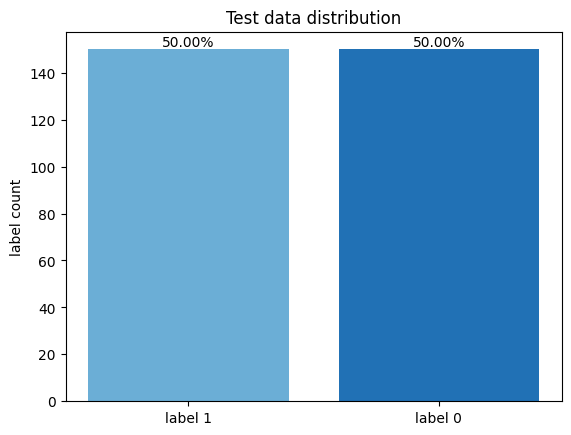

In [ ]:
def plot_data_distribution(df: pd.DataFrame) -> None:

    """
    Shows the distribution of a dataset split.

    Input:
    df: split of the dataset (pd.DataFrame)
    """

    label_1 = len(df[df["label_sexist"] == 1])
    label_0 = len(df[df["label_sexist"] == 0])
    bar_colors = ["#6baed6", "#2171b5"]
    bars = plt.bar(["label 1", "label 0"], [label_1, label_0], color=bar_colors)
    percentages = [label_1 / len(df)*100, label_0 / len(df)*100]
    for bar, percentage in zip(bars, percentages):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{percentage:.2f}%",
            ha="center",
            va="bottom",
        )
    plt.title('Test data distribution')
    plt.ylabel("label count")
    plt.show()

plot_data_distribution(a2_test)

As we can see from the plot the test set is perfectly balanced between the sexism (label 1) and not sexism (label 0).

In [ ]:
test_data = Dataset.from_pandas(a2_test)
ground_truth = np.array(test_data['label_sexist'])

# [Task 1 - 0.5 points] Model setup







Once the test data has been loaded, we have to setup the model pipeline for inference.







In particular, we have to:



- Load the model weights from Huggingface



- Quantize the model to fit into a single-GPU limited hardware

## Which LLMs?







The pool of LLMs is ever increasing and it's impossible to keep track of all new entries.







We focus on popular open-source models.







- [Mistral v2](mistralai/Mistral-7B-Instruct-v0.2)



- [Mistral v3](mistralai/Mistral-7B-Instruct-v0.3)



- [Llama v3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)



- [Phi3-mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct)







Other open-source models are more than welcome!

### Instructions







In order to get Task 1 points, we require you to:







* Pick 2 model cards from the provided list.



* For each model:



  - Define a separate section of your notebook for the model.



  - Setup a quantization configuration for the model.



  - Load the model via HuggingFace APIs.


### Notes







1. There's a popular library integrated with Huggingface's ``transformers`` to perform quantization.







2. Define two separate sections of your notebook to show that you have implemented the prompting pipeline for each selected model card.

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [ ]:
def get_model(model_card : str) -> tuple:

    """
    Download the model and its tokenizer from Hugging Face and set the configuratons

    Input:
    model_card: name of the model to dowload

    Output:
    model: the downloaded model
    tokenizer: the tokenizer associated with the model
    """
    tokenizer = AutoTokenizer.from_pretrained(model_card)
    tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_card,
        return_dict=True,
        quantization_config=bnb_config,
        device_map='auto'
    )

    generation_config = model.generation_config
    generation_config.max_new_tokens = 100
    generation_config.eos_token_id = tokenizer.eos_token_id
    generation_config.pad_token_id = tokenizer.eos_token_id
    generation_config.temperature = None
    generation_config.num_return_sequences = 1

    return model, tokenizer

We decide to use Phi3-mini, a model with 3.8 billions parameters developed by Microsoft.  

In [ ]:
model_card = "microsoft/Phi-3-mini-4k-instruct"

model_1, tokenizer_1 = get_model(model_card)

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

# [Task 2 - 1.0 points] Prompt setup







Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


## Prompt Template







Use the following prompt template to process input texts.

In [ ]:
zero_shot_prompt = [
    {

        'role': 'system',
        'content': 'You are an annotator for sexism detection.'

    },

    {

        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """

    }

]

### Instructions







In order to get Task 2 points, we require you to:







* Write a ``prepare_prompts`` function as the one reported below.

In [ ]:
def prepare_prompts(texts: Dataset, prompt_template: list, tokenizer: transformers.AutoTokenizer) -> DataLoader:

    """
     Formats input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
    """

    def collate_fn(batch):
        texts = tokenizer.batch_encode_plus([it['text'] for it in batch], return_tensors='pt', padding=True, truncation=True)
        sentiment = torch.tensor([it['label_sexist'] for it in batch])
        return texts, sentiment

    def format_text(text):
        prompt = tokenizer.apply_chat_template(prompt_template, tokenize=False, add_generation_prompt=True)
        text['text'] = prompt.format(text=text['text'])
        return text

    zero_shot_data = texts.map(lambda x: format_text(x))
    zero_shot_data = zero_shot_data.select_columns(['text', 'label_sexist'])

    print(zero_shot_data['text'][0])
    data_loader = DataLoader(zero_shot_data,
                             batch_size=1,
                             shuffle=False,
                             collate_fn=collate_fn)

    return data_loader

In [ ]:
data_loader = prepare_prompts(test_data, zero_shot_prompt, tokenizer_1)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

<|system|>
You are an annotator for sexism detection.<|end|>
<|user|>
Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        <|end|>
<|assistant|>



### Notes







1. You are free to modify the prompt format (**not its content**) as you like depending on your code implementation.







2. Note that the provided prompt has placeholders. You need to format the string to replace placeholders. Huggingface might have dedicated APIs for this.

# [Task 3 - 1.0 points] Inference







We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions







In order to get Task 3 points, we require you to:







* Write a ``generate_responses`` function as the one reported below.



* Write a ``process_response`` function as the one reported below.

In [ ]:
def generate_responses(model: transformers.AutoModel, prompt_examples: DataLoader) -> list:

    """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
    """

    model_responses = []
    with torch.inference_mode():
        for batch_x, batch_y in tqdm(prompt_examples, desc="Generating responses"):
            response = model.generate(

                input_ids=batch_x['input_ids'].to(model.device),
                attention_mask=batch_x['attention_mask'].to(model.device),
                generation_config=model.generation_config,
                do_sample=False,
                use_cache=True

            )

            model_responses.extend(response)

    return model_responses

In [ ]:
def process_response(response: str) -> int:

    """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
    """

    return 1 if response.split()[0] == 'YES' else 0

In [ ]:
def extract_response(response: str) -> str:

    """
    Extracts the answer of the model.

    Input:
    respose: the whole prompt given by the model
    """

    match = [m for m in re.finditer(f'ANSWER:', response)][-1]
    parsed = response[match.end():].strip()
    return parsed

In [ ]:
phi_pred = generate_responses(model_1, data_loader)

Generating responses: 100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


In [ ]:
response = tokenizer_1.batch_decode(phi_pred, skip_special_tokens=True)
raw_response = np.array([extract_response(item) for item in response])

Let's create a Dataframe which will be used after to address the error of the models

In [ ]:
responses_df = a2_test.copy()
responses_df = responses_df.drop('rewire_id', axis=1)
responses_df['phi3_zero_shot'] = raw_response

## Notes







1. According to our tests, it should take you ~10 mins to perform full inference on 300 samples.

# [Task 4 - 0.5 points] Metrics







In order to evaluate selected LLMs, we need to compute performance metrics.







In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.







Moreover, we want to compute the ratio of failed responses generated by models.







That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.







We denote this metric as **fail-ratio**.







In summary, we parse generated responses as follows:



- 1 if the model says YES



- 0 if the model says NO



- 0 if the model does not answer in either way

### Instructions







In order to get Task 4 points, we require you to:







* Write a ``compute_metrics`` function as the one reported below.



* Compute metrics for the two selected LLMs.

We considered wrong answers all those who do not contain either yes or no (case unsensitive) in the answer; an answer of the form: yes (or no) + explanation will be considered corrected. This allowed us to define the fail ratio as the ratio of the wrong answers.

In [ ]:
def fail_ratio(textual_response : list) -> float:

    """
    Computes the fail-ratio metrics
    Input:
    textual_response:  the responses generated by the model

    Output:
    fail_ratio: the fail ratio metrics
    """
    wrong_answer = [answer for answer in textual_response if ('YES' not in answer.upper() and 'NO' not in answer.upper())]
    n_wrong = len(wrong_answer)
    n_total = len(textual_response)
    fail_ratio = n_wrong/n_total
    return fail_ratio

In [ ]:
def compute_metrics(responses: np.ndarray, y_true: np.ndarray) -> dict:

    """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function computes accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
      responses: generated LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
    """

    fail = fail_ratio(responses)
    binary_prediction = [process_response(item) for item in responses]
    predictions = np.array(binary_prediction)
    acc = accuracy_score(y_pred=predictions, y_true=y_true)
    cm = confusion_matrix(y_pred=predictions, y_true=y_true)
    cr = classification_report(y_pred=predictions, y_true=y_true, output_dict = True)

    return {'fail_ratio' : fail, 'accuracy_score' : acc, 'cr': cr, 'cm': cm}

In [ ]:
metrics_zero_shot_phi = compute_metrics(raw_response, ground_truth)
print(f"""fail_ratio: {metrics_zero_shot_phi["fail_ratio"]:.4f},
accuracy: {metrics_zero_shot_phi["accuracy_score"]:.4f}
""")
metrics = {'phi3_zero_shot': metrics_zero_shot_phi}

fail_ratio: 0.0000,
accuracy: 0.6433



# [Task 5 - 1.0 points] Few-shot Inference







So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.







We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.







To do so, we slightly change the prompt template as follows.

In [ ]:
few_shot_prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.







Generally, we provide an equal number of demonstrations per class as shown in the example below.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]

## Instructions







In order to get Task 5 points, we require you to:







- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.



- Define a ``build_few_shot_demonstrations`` function as the one reported below.



- Perform few-shot inference as in Task 3.



- Compute metrics as in Task 4.

Load demonstrations.csv and encode it into a pandas.DataFrame object, mapping the taget feature in YES and NO.

In [ ]:
local_file_path = os.path.join(directory, 'demonstrations')
label_mapping = {'sexist': 'YES', 'not sexist': 'NO'}
demonstrations = pd.read_csv(local_file_path, converters={'label_sexist' : lambda x: label_mapping[x]})
demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,NO
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,YES
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,NO
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,YES
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,YES


Define a build_few_shot_demonstrations function as the one reported below

In [ ]:
def build_few_shot_demonstrations(demonstrations: pd.DataFrame, num_per_class: int=2) -> str:

    """
    This function extracts random examples from the demonstrations.

    Inputs:

      demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      a string of textual demonstrations to inject into the prompt template.
    """

    demonstration_list = []
    for i in range(num_per_class):
        demonstration_list.append((demonstrations[demonstrations['label_sexist'] == 'YES'].sample(1, axis = 0)['text'].values[0], 'YES'))
        demonstration_list.append((demonstrations[demonstrations['label_sexist'] == 'NO'].sample(1, axis = 0)['text'].values[0], 'NO'))

    demonstration_samples = '\n'.join([f'TEXT: {text}\nANSWER: {answer}' for (text, answer) in demonstration_list])
    return demonstration_samples

In [ ]:
def prepare_prompts_few_shot(texts: Dataset,
                             prompt_template: list,
                             tokenizer: transformers.AutoTokenizer,
                             demonstration_samples: Optional[str] = None,
                             num_per_class: int = 2) -> DataLoader:

    """
    This function formats input text samples into instructions prompts with examples.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card
      demonstration_samples: the examples used to format the prompt

    Outputs:
      input texts to classify in the form of instruction prompts
    """

    def format_text(text):
        prompt = tokenizer.apply_chat_template(prompt_template, tokenize=False, add_generation_prompt=True)
        if demonstration_samples is None:
          text['text'] = prompt.format(text=text['text'], examples= build_few_shot_demonstrations(demonstrations, num_per_class = num_per_class))
        else:
          text['text'] = prompt.format(text=text['text'], examples= demonstration_samples)
        return text

    def collate_fn(batch):
        texts = tokenizer.batch_encode_plus([it['text'] for it in batch], return_tensors='pt', padding=True, truncation=True)
        sentiment = torch.tensor([it['label_sexist'] for it in batch])
        return texts, sentiment

    few_shot_data = texts.map(lambda x: format_text(x))
    few_shot_data = few_shot_data.select_columns(['text', 'label_sexist'])

    print(few_shot_data['text'][0])
    data_loader = DataLoader(few_shot_data,
                             batch_size=1,
                             shuffle=False,
                             collate_fn=collate_fn)


    return data_loader

To ensure reproducibility and a fair comparison between the models, we limited the demonstrations to two examples per class, randomly extracted from the demonstrations file. All prompt templates are then formatted using the extracted sentences from the dataset and the same fixed set of demonstrations for consistency across all experiments.

In [ ]:
demonstration_samples = build_few_shot_demonstrations(demonstrations, num_per_class=2)
print(demonstration_samples)

TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
ANSWER: YES
TEXT: Reposting this since all the mailboxes were full over the weekend. Please everybody call! #ReleaseTheMemo
ANSWER: NO
TEXT: It's not old. The women that are 35+ are far more mature, know what they want, and go for it. They don't play the same games and I appreciate them far more for it. Also, they fuck you so much better... no joke.
ANSWER: YES
TEXT: Greece, African and moslems first stop to the UK.
ANSWER: NO


In [ ]:
data_loader_fs = prepare_prompts_few_shot(test_data, prompt_template= few_shot_prompt, tokenizer= tokenizer_1, demonstration_samples= demonstration_samples)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

<|system|>
You are an annotator for sexism detection.<|end|>
<|user|>
Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
ANSWER: YES
TEXT: Reposting this since all the mailboxes were full over the weekend. Please everybody call! #ReleaseTheMemo
ANSWER: NO
TEXT: It's not old. The women that are 35+ are far more mature, know what they want, and go for it. They don't play the same games and I appreciate them far more for it. Also, they fuck you so much better... no joke.
ANSWER: YES
TEXT: Greece, African and moslems first stop to the UK.
ANSWER: NO

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        <|end|>
<|assistant|>



Perform few-shot inference as in Task 3.

In [ ]:
phi_pred_fs = generate_responses(model_1, data_loader_fs)

Generating responses: 100%|██████████| 300/300 [03:38<00:00,  1.37it/s]


In [ ]:
response = tokenizer_1.batch_decode(phi_pred_fs, skip_special_tokens=True)
raw_response = np.array([extract_response(item) for item in response])
responses_df['phi3_few_shot'] = raw_response

Compute metrics as in Task 4.

In [ ]:
metrics_few_shot_phi = compute_metrics(raw_response, ground_truth)
metrics['phi3_few_shot'] = metrics_few_shot_phi

print(f"""fail_ratio: {metrics_few_shot_phi["fail_ratio"]:.4f},
accuracy: {metrics_few_shot_phi["accuracy_score"]:.4f}
"""
)

fail_ratio: 0.0000,
accuracy: 0.6700



## Notes







1. You are free to pick any value for ``num_per_class``.







2. According to our tests, few-shot prompting increases inference time by some minutes (we experimented with ``num_per_class`` $\in [2, 4]$).

# Model 2 - Mistral 7B v0.3

In this section we performed zero shot and few shot techniques on the model **Mistral 7B instruct v0.3** of MistralAI.

In [ ]:
model_card = "mistralai/Mistral-7B-Instruct-v0.3"

model_2, tokenizer_2= get_model(model_card)

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Zero-Shot

In [ ]:
data_loader = prepare_prompts(test_data, zero_shot_prompt, tokenizer_2)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [ ]:
mistral_pred_zs = generate_responses(model_2, data_loader)

Generating responses: 100%|██████████| 300/300 [03:55<00:00,  1.28it/s]


In [ ]:
response = tokenizer_2.batch_decode(mistral_pred_zs, skip_special_tokens=True)
raw_response = np.array([extract_response(item) for item in response])
responses_df['mistral_zero_shot'] = raw_response

In [ ]:
metrics_mistral_zero_shot = compute_metrics(raw_response, ground_truth)
metrics['mistral_zero_shot'] = metrics_mistral_zero_shot

print(f"""fail_ratio: {metrics_mistral_zero_shot["fail_ratio"]:.4f},
accuracy: {metrics_mistral_zero_shot["accuracy_score"]:.4f}
""")

fail_ratio: 0.0000,
accuracy: 0.5900



### Few-Shot

In [ ]:
data_loader_fs = prepare_prompts_few_shot(test_data, prompt_template= few_shot_prompt, tokenizer= tokenizer_2, demonstration_samples= demonstration_samples)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
ANSWER: YES
TEXT: Reposting this since all the mailboxes were full over the weekend. Please everybody call! #ReleaseTheMemo
ANSWER: NO
TEXT: It's not old. The women that are 35+ are far more mature, know what they want, and go for it. They don't play the same games and I appreciate them far more for it. Also, they fuck you so much better... no joke.
ANSWER: YES
TEXT: Greece, African and moslems first stop to the UK.
ANSWER: NO

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [ ]:
mistral_pred_fs = generate_responses(model_2, data_loader_fs)
response = tokenizer_2.batch_decode(mistral_pred_fs, skip_special_tokens=True)
raw_response = np.array([extract_response(item) for item in response])
responses_df['mistral_few_shot'] = raw_response

Generating responses: 100%|██████████| 300/300 [07:03<00:00,  1.41s/it]


In [ ]:
metrics_mistral_few_shot = compute_metrics(raw_response, ground_truth)
metrics['mistral_few_shot'] = metrics_mistral_few_shot

print(f"""fail_ratio: {metrics_mistral_few_shot["fail_ratio"]:.4f},
accuracy: {metrics_mistral_few_shot["accuracy_score"]:.4f}
""")

fail_ratio: 0.0000,
accuracy: 0.6967



# [Task 6 - 1.0 points] Error Analysis







We are now interested in evaluating model responses and comparing their performance.







This analysis helps us in understanding







- Classification task performance gap: are the models good at this task?



- Generation quality: which kind of responses do models generate?



- Errors: which kind of mistakes do models do?

### Instructions







In order to get Task 6 points, we require you to:







* Compare classification performance of selected LLMs in a Table.



* Compute confusion matrices for selected LLMs.



* Briefly summarize your observations on generated responses.

## Model performances

Let's explore the Confusion Matrix and Classification Reports of the models to analyse the errors.

In [ ]:
def plot_results(model_name : str, metrics : dict) -> None:

    """
    This function plots the confusion matrix and classification report of the desired model
    for both the zero shot and few shot

    Input
    model_name: the name of the model to plot the metrics of
    metrics: a dictionary containing the computed metrics
    """

    fig, axs = plt.subplots(2,2, figsize=(10, 5))
    keys = [key for key in metrics.keys() if model_name in key]

    for idx, key in enumerate(keys):
        cm = metrics[key]['cm']
        disp = ConfusionMatrixDisplay(cm)
        axs[0][idx].set_title(key)
        disp.plot(ax=axs[0][idx], colorbar=False, cmap='Blues')

        cr = metrics[key]['cr']

        report_df = pd.DataFrame(cr).T
        report_df.iloc[:, :-1] = report_df.iloc[:, :-1].round(2)
        report_df.loc["accuracy", ["precision", "recall"]] = None
        report_df.loc["accuracy", "support"] = 300

        # Create a styled table
        axs[1][idx].axis("off")
        table_data = report_df.reset_index()
        table = axs[1][idx].table(cellText=table_data.values, colLabels=table_data.columns,
                        cellLoc="center", loc="center", bbox=[0, 0, 1, 1])

        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width(col=list(range(len(table_data.columns))))

        # Apply styles to headers and rows
        for (row, col), cell in table.get_celld().items():
            cell.set_edgecolor("black")
            if row == 0:
                cell.set_text_props(weight="bold")
                cell.set_facecolor("#f4f4f4")
            elif col == 0:
                cell.set_text_props(weight="bold")
                cell.set_facecolor("#f4f4f4")
            else:
                value = table_data.values[row - 1, col] if row > 0 else table_data.columns[col]  # Adjust index for header
                if pd.isna(value):
                    cell.get_text().set_text("")
                cell.set_facecolor("white")
                cell.set_alpha(0.9)

        axs[1][idx].set_title(key, fontsize=14)

    plt.tight_layout()
    plt.show()

Observing **Phi3** confusion matrix and classification report we can note that:
- the error are quite balanced in both the zero shot and few shot between the sexist and non sexist label; this is confirmed also by the classification report, indeed the precision and recall on zero shot are basically equal, this is positive since the models seems to not present strong imbalances.
- from the accuracy score we can see that the perfomances slightly increase in the few shot, this was expected since providing demonstration should help the model to better classify sentences. Diving deeper we can notice that only 6 sentences more are correctly classified in few shot, with respect to zero shot and all of them are from the label 1. This lead to different values in precision and recall and it could imply that the demonstration sentences, taken randomly, only help the model to understand sexism.

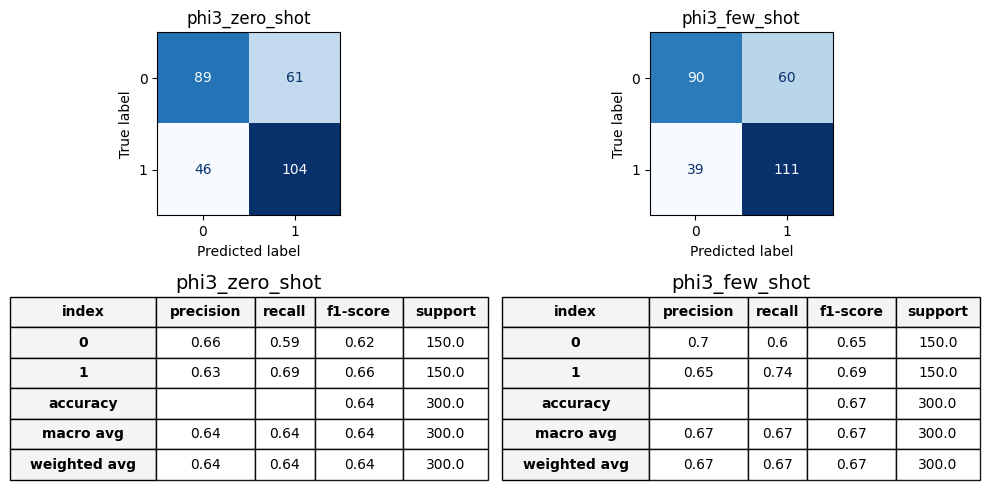

In [ ]:
plot_results('phi', metrics)

Observing **Mistral v0.3** confusion matrix and classification report we can note that:
- The errors are highly imbalanced in the zero shot, indeed the model almost predicts all the sentences as sexist. Precision and recall are completely different on label 0, highlighting the fact that almost all sentences have been wrongly classified. In fact, the accuracy is slightly better than the one of the random classifier (0.59).
- In few-shot, the performance improves, reaching 0.7 accuracy. This improvement highlights, even more than Phi3, the importance of the examples provided. However, the model remains strongly imbalanced in its predictions, with 81 of the total errors made on label 1. Additionally, we observe a slight decrease in Mistral's performance on label 1 in few-shot, with the model misclassifying 7 more sentences compared to zero-shot

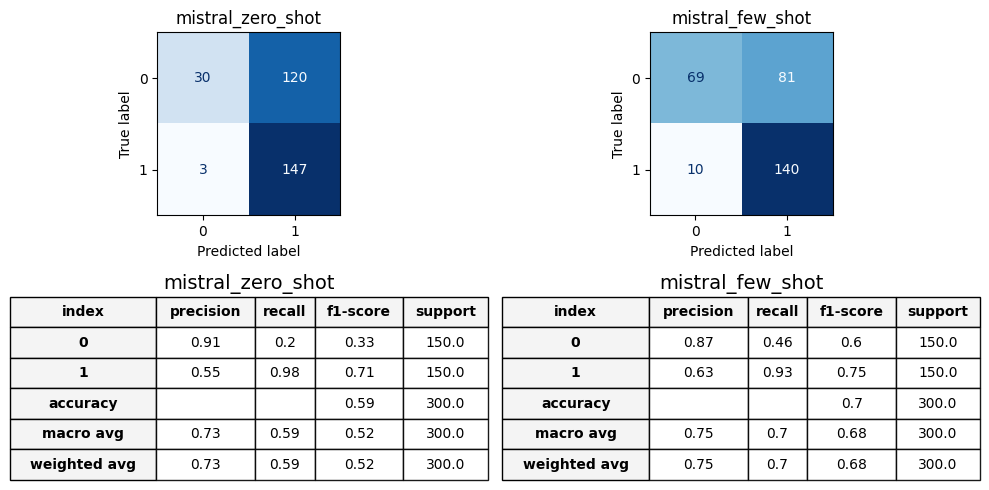

In [ ]:
plot_results('mistral', metrics)

After analyzing the performance of each model individually, let's now compare them by focusing on the key metrics.

In [ ]:
def show_performances_table(metrics : dict, save_file : bool = False, file_name : str = None) -> None:

    """
    Shows in table format the metrics contained in the metrics_dict and saved them as a tex table whether required

    Input
    metrics: dictionary containing the metrics to show in table format
    save_file: boolean attribute, specify whther the table will be saved in your local environment
    file_name: the name of the file to be saved with
    """

    if save_file and file_name is None:
        raise ValueError("file_name must be specified if save_file is setted to True")

    performances = {'accuracy_score':[], 'fail_ratio':[], 'f1-score':[]}

    for key in metrics.keys():
      performances['accuracy_score'].append(metrics[key]['accuracy_score'])
      performances['fail_ratio'].append(metrics[key]['fail_ratio'])
      for k in metrics[key]['cr']['macro avg'].keys():
        if k in performances:
          performances[k].append(metrics[key]['cr']['weighted avg'][k])

    df = pd.DataFrame.from_dict(performances, orient='index', columns=metrics.keys())
    df = df.map(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
    df = df.T
    print(tabulate(df, headers=df.columns, tablefmt="fancy_grid"))

    if save_file:
      latex_table = tabulate(df, headers=df.columns, tablefmt="latex")
      with open(f"{file_name}.tex", "w") as f:
        f.write(latex_table)

In [ ]:
show_performances_table(metrics, save_file= True, file_name= 'overall_results')

╒═══════════════════╤══════════════════╤══════════════╤════════════╕
│                   │   accuracy_score │   fail_ratio │   f1-score │
╞═══════════════════╪══════════════════╪══════════════╪════════════╡
│ phi3_zero_shot    │            0.643 │            0 │      0.642 │
├───────────────────┼──────────────────┼──────────────┼────────────┤
│ phi3_few_shot     │            0.67  │            0 │      0.668 │
├───────────────────┼──────────────────┼──────────────┼────────────┤
│ mistral_zero_shot │            0.59  │            0 │      0.516 │
├───────────────────┼──────────────────┼──────────────┼────────────┤
│ mistral_few_shot  │            0.697 │            0 │      0.679 │
╘═══════════════════╧══════════════════╧══════════════╧════════════╛


By presenting the main metrics of the models in a table, we observe that all of them achieve the maximum possible score in fail_ratio, as none of the models produce incorrect answers.

Phi3 performs better in the zero-shot setting, but this may be due to the significant imbalance in Mistral's predictions, as previously discussed. However, in the few-shot setting, Mistral shows a significant improvement, surpassing Phi3. This improvement could be attributed to Mistral's larger size, with 7B parameters compared to 3.8B in Phi3. We hypothesize that the higher number of parameters helps Mistral better leverage the provided examples, resulting in improved few-shot performance.

### Further analysis
To better understand the factors that lead the model to make errors, we conduct two explorations:
- Since we limit the model's token generation to 100 tokens and just one sentence, it is possible that some answers are followed by explanations. Including these explanations could provide a clearer understanding of the errors. We analyse whether such answers exist and identify which of them are misclassified.
- We decide to plot all the words that appear more frequently in misclassified sentences. This is done to explore whether certain words are common across the models and whether they carry significant meaning for our task. Stop words are excluded to avoid misleading comparisons.

### Wrong answers Exploration
We decide to explore all those misclassified sentences whose answer is followed by an explanation.

The output is structured in the following way:

- first line: the sentence misclassified
- second line: the ground truth label
- third line: the answer of the model

In [ ]:
def display_sentence_explained(
                    predictions_df : pd.DataFrame,
                    model_name: str) -> None:
    """
      Displays misclassified sentences with explanations.

    Input:
    predictions_df: a DataFrame containing the sentences, predictions and labels. (pd.DataFrame)
    model_name: name of the model for the plot title (str)
    """

    def map_response(value):
        if value.startswith('YES'):
            return 1
        elif value.startswith('NO'):
            return 0

    predictions_df[f'{model_name}_mapped'] = predictions_df[model_name].apply(map_response)
    predictions_df = predictions_df[~predictions_df[model_name].isin(['YES', 'NO'])]
    predictions_df = predictions_df[predictions_df['label_sexist'] != predictions_df[f'{model_name}_mapped']].reset_index(drop=True)
    if len(predictions_df) == 0:
      print('No answer with explanation given')
    for rows in predictions_df.iterrows():
        true_label = 'YES' if rows[1]["label_sexist"] == 1 else 'NO'
        print(f'{rows[1]["text"]} \nground truth: {true_label} \nmodel pred: {rows[1][model_name]}')
        print('='*80)

### Phi3
As we can see below, Phi3 model never gives an answer followed by an explanation, no analysis can be performed.

In [ ]:
display_sentence_explained(responses_df.copy(), model_name= 'phi3_zero_shot')

No answer with explanation given


In [ ]:
display_sentence_explained(responses_df.copy(), model_name= 'phi3_few_shot')

No answer with explanation given


### Mistral

Looking at the answers given by Mistral, and the queried sentences, we notice that all the sentences are quite difficult to understand even for a human. Indeed, the explanation given is not completly wrong, but it seems like the model is not able to catch up the undertone meaning of the sentences.

In [ ]:
display_sentence_explained(responses_df.copy(), model_name= 'mistral_zero_shot')

Tell that to Weev you lying shitskin son of a bitch. 
ground truth: YES 
model pred: NO (The text does not contain sexism. It is an insulting and offensive language, but it does not specifically target a person based on their gender.)


In [ ]:
display_sentence_explained(responses_df.copy(), model_name= 'mistral_few_shot')

Good - the grid girls can finally get back into F1 
ground truth: NO 
model pred: YES (This statement objectifies women and reduces them to their physical appearance, which is a form of sexism.)
The new Europeans are into all kinds of sex.... 
ground truth: NO 
model pred: YES (This statement seems to stereotype a group of people based on their nationality, which could be considered as a form of ethnic prejudice, not necessarily sexism, but it's important to note that ethnic prejudice can intersect with sexism.)
This is about false rape charges and how wives use the laws to torture and get money from the brides family.....highly recommend to watch full video ....its mind blowing 
ground truth: NO 
model pred: YES (The text seems to stereotype all wives, implying that they are prone to false rape charges and using the law to torture and extort money, which is a generalization and potentially harmful towards women.)
My state? I'm not Jewish. They literally won't stop until they destroy I

## Word exploration

Let's explore whether any error patterns correlated with specific words emerge from the analysis.

In [ ]:
def plot_wrong_word(predictions_df: pd.DataFrame,
                    model_name: str,
                    top_wrongest: int = 20) -> None:

    """
    Shows the most frequent words in wrong classified sentences.

    Input:
    predictions_df: a DataFrame containing the sentences, predictions and labels. (pd.DataFrame)
    model_name: name of the model for the plot title (str)
    top_wrongest: number of words to show (int)
    """

    def find_wrongest(df: pd.DataFrame, label: int, ax: matplotlib.axes.Axes) -> None:
        df = df[df["label_sexist"] == label]
        all_words = Counter(
            word for row in df["text"] for word in row.split() if word not in stop_words
        )
        df_wrong = df[df['label_sexist'] != df[model_name]]
        wrongest_words = Counter(
            word for row in df_wrong["text"] for word in row.split() if word not in stop_words
        )

        wr_words, wr_counts = zip(*wrongest_words.most_common(top_wrongest)[:0:-1])
        ax.barh(wr_words, wr_counts, color="skyblue", label='Wrong Sentences')
        counts = [all_words[word] for word in wr_words]
        ax.barh(wr_words, counts, color="skyblue",alpha=0.4, label='All Sentences')
        ax.set_title(f"Wrongest words in label {label}")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend()

    def map_response(value):
        if value.startswith('YES'):
            return 1
        elif value.startswith('NO'):
            return 0

    predictions_df[f'{model_name}'] = predictions_df[model_name].apply(map_response)
    stop_words = list(stopwords.words("english"))

    fig, axs = plt.subplots(1,2, figsize=(10,5))
    fig.suptitle(f'{model_name} charts', weight="bold")
    find_wrongest(predictions_df, 0, axs[0])
    find_wrongest(predictions_df, 1, axs[1])
    plt.tight_layout()
    plt.show()

### Phi3

In the zero-shot setting, the model appears to show a possible bias towards associating terms like "**women**" and "**woman**" with errors in label 0 (non-sexist).

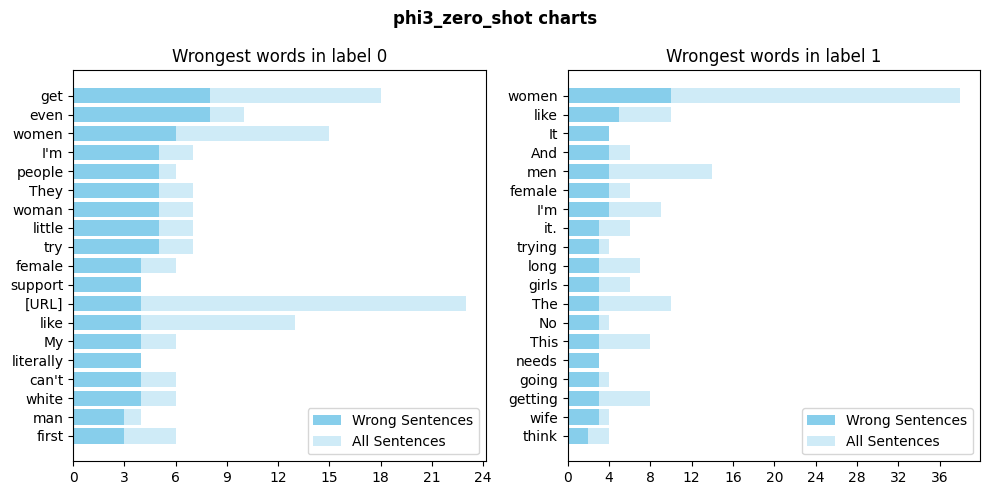

In [ ]:
plot_wrong_word(responses_df.copy(), model_name= 'phi3_zero_shot')

In the few-shot setting certain patterns seem to persist, particularly for label 0 errors. This could indicate that the examples provided during few-shot prompting, although helpful, may not fully address the model's tendency to misclassify based on specific terms.

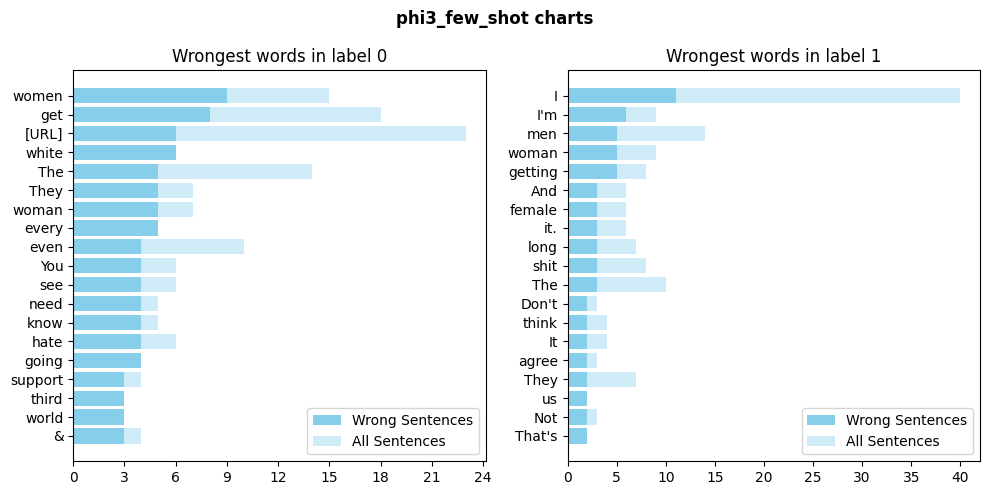

In [ ]:
plot_wrong_word(responses_df.copy(), model_name= 'phi3_few_shot')

### Mistral

From Mistral zero shot word exploration we can see:
- In label 0 all the **woman-related** occurrences (women, girls, woman, female) have almost a 100% wrong ratio. But, remembering the confusion matrix above, this result is not so meaningful, since almost all the sentences are wrongly classified. We can hypotesise that almost all the words have a 100% wrong ratio.
- In label 1, the number of misclassified sentences is very low (only 3), which makes it difficult to draw meaningful conclusions or identify clear patterns for this category.

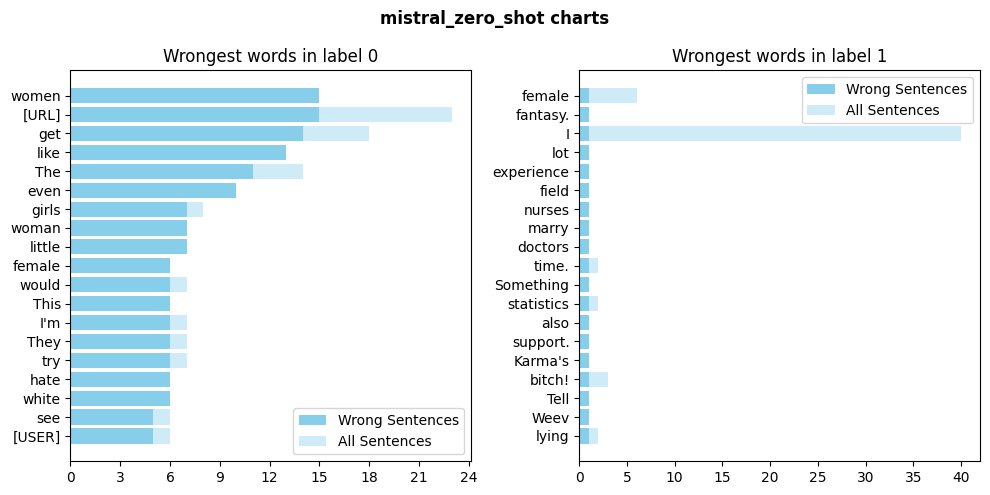

In [ ]:
plot_wrong_word(responses_df.copy(), model_name= 'mistral_zero_shot')

From Mistral few shot word exploration we can see:
- in label 0 the words that are most frequently misclassified include the woman-related ones (women, woman, girls, female). This could highlight some biases in the model that almost always associate a woman-related word to sexism. The presence of terms like "**fat**" and "**white**" also raises questions about the potential biases in the model, as these terms could be linked to specific stereotypes or contexts the model misinterprets.
- in label 1 the diversity of terms could suggest a broader range of possible contexts or tasks where the model struggles, but thinking about the confusion matrix this could be probably related to the low number of errors (10).

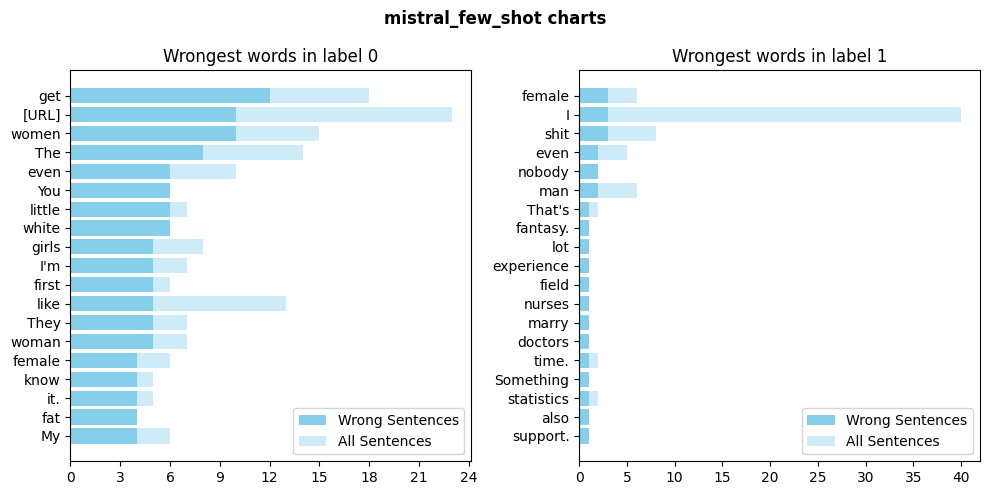

In [ ]:
plot_wrong_word(responses_df.copy(), model_name= 'mistral_few_shot')

## Few Shot Experiments

We would like to analyse how much the predictions of the models, and consequently their performances, were correlated with the examples injected through the model prompt.

In [ ]:
def plot_variability(mode : str, demonstration_list : list = [], num_per_class : list = [], to_save : bool = True ) -> None:

    """
    Computes the metrics with different examples per classes.

    Input:
    mode: whether we are computing the quality or quantity variability
    demonstration_list: the list containting the demonstrations to be used
    num_per_class: a list containing the number of elements per class to use in the few shot prompting, to use whether demonstration_list is empty
    to_save: boolean attribute, specify whther the table will be saved in your local environment
    """
    if demonstration_list == [] and num_per_class == []:
      assert ValueError('At least one between demonstration_list and num_per_class should be not default')

    n_experiments = len(demonstration_list) if demonstration_list != [] else len(num_per_class)

    def compute_metric_list(model, tokenizer, ax, model_name):

        metric_list = {'fail_ratio' : [], 'accuracy' : [], 'examples' : []}

        for n_example in tqdm(range(n_experiments), desc="Generating responses"):

            with capture_output():
                if demonstration_list != []:
                  data_loader = prepare_prompts_few_shot(test_data, prompt_template= few_shot_prompt,
                                                         tokenizer= tokenizer, demonstration_samples= demonstration_list[n_example])
                  metric_list['examples'].append(demonstration_list[n_example])
                else:
                  data_loader = prepare_prompts_few_shot(test_data, prompt_template= few_shot_prompt,
                                                         tokenizer= tokenizer, num_per_class = num_per_class[n_example])
                y_pred = generate_responses(model, data_loader)

            response = tokenizer.batch_decode(y_pred, skip_special_tokens=True)
            raw_response = np.array([extract_response(item) for item in response])

            metrics = compute_metrics(raw_response, ground_truth)
            metric_list['accuracy'].append(metrics["accuracy_score"])
            metric_list['fail_ratio'].append(metrics["fail_ratio"])


            #json files checkpoints
            if to_save:
              if model == model_1:
                  if mode == 'quality':
                      with open(f"metric_list_quality_phi_{n_example}.json", "w") as json_file:
                          json.dump(metric_list, json_file, indent=4)
                  else:
                      with open(f"metric_list_quantity_phi_{n_example}.json", "w") as json_file:
                          json.dump(metric_list, json_file, indent=4)
              else:
                  if mode == 'quality':
                      with open(f"metric_list_quality_mistral_{n_example}.json", "w") as json_file:
                          json.dump(metric_list, json_file, indent=4)
                  else:
                      with open(f"metric_list_quantity_mistral_{n_example}.json", "w") as json_file:
                          json.dump(metric_list, json_file, indent=4)


        bars = ax.bar(range(1, n_experiments+1), metric_list['accuracy'])
        x = np.arange(1, len(metric_list['accuracy']) + 1)
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')
        if mode == 'quality':
            ax.set_xticks([])
            ax.set_xlabel('Experiments')
        else:
            ax.set_xticks(np.arange(1, n_experiments+1, 1))
            ax.set_xlabel('Number of examples')
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.set_ylabel('Accuracy score')
        ax.set_title(f'{model_name}')

    fig, axs = plt.subplots(1, 2, figsize= (12, 5))

    if mode == 'quality':
        plt.suptitle(f'Accuracy variability choosing 2 different examples per class')
    else:
        plt.suptitle(f'Accuracy variability increasing the number of examples per class')

    compute_metric_list(model_1, tokenizer_1, axs[0], 'Phi3')
    compute_metric_list(model_2, tokenizer_2, axs[1], 'Mistral')

    plt.show()

### Qualitative Analysis

The first analysis investigates how the model's performance is influenced by the examples provided in the few-shot setup. In this experiment, the model generates predictions ten times, using a different set of examples in the prompt for each run. In each case, two examples per class are randomly selected and remain consistent throughout that specific run. This approach allows us to observe how the choice of examples impacts the model's output.

From the plot below, we can observe that for both models, their performance fluctuates significantly depending on the examples given as input. This suggests that the choice of few-shot examples can heavily influence the model's predictions, highlighting the sensitivity of the few-shot approach to input selection.

Such variability underscores the importance of carefully curating examples for few-shot learning tasks to ensure robust and consistent performance.

Generating responses: 100%|██████████| 10/10 [1:12:14<00:00, 433.48s/it]


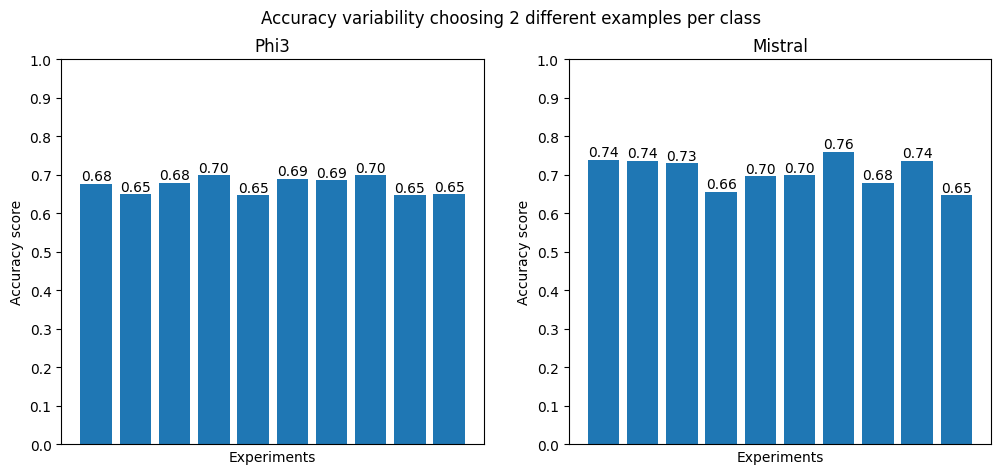

In [ ]:
n_experiments = 10
demonstration_quality_var = [build_few_shot_demonstrations(demonstrations, num_per_class= 2) for idx in range(n_experiments)]

plot_variability(mode= 'quality', demonstration_list= demonstration_quality_var)

To address this issue, we decide to modify the examples provided in each prompt by randomly selecting them during each run. This approach ensures that within a single run, each of the 300 prompts contains a different set of examples, resulting in a total of 1,200 unique examples sampled from the demonstration dataset. By introducing this variability, we aim to reduce the model's sensitivity to specific fixed examples.
We conduct 10 separate experiments to maintain consistency with the previous analysis. This experimental setup allows us to make more robust comparisons and avoid drawing false conclusions based on isolated runs.

From the plots below, it is evident that, although some degree of variability in performance persists, the fluctuations are significantly reduced compared to when using a fixed set of examples across all prompts. This indicates that varying the examples contributes to a more stable model performance and reduces its sensitivity to specific demonstrations.

Furthermore, it is important to note that none of the trials achieve peak performance. This observation suggests that the choice of examples is central in few-shot prompting, as the examples directly influence the model's ability to generalize and adapt to the task. To achieve the best possible results, examples should be carefully selected.

Based on these findings, we decide to consistently adopt the strategy of varying the examples in subsequent experiments.

Generating responses: 100%|██████████| 10/10 [1:12:39<00:00, 436.00s/it]


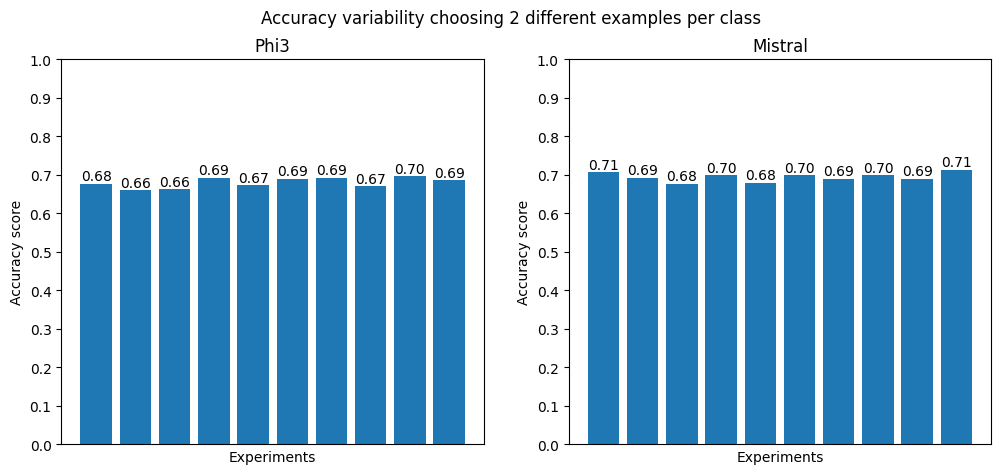

In [ ]:
n_experiments= 10

plot_variability(mode= 'quality', num_per_class= [2]*n_experiments, to_save = False)

### Quantitative Analysis

We also conducted experiments to investigate the impact of varying the number of examples per class on model performance. By testing a range spanning from 1 to 5 examples per class, we observed that there was no clear correlation between the number of examples and the overall accuracy. Interestingly, the results suggest that using two or three examples per class tends to yield the most stable and optimal performance.

This finding indicates that beyond a certain point, increasing the number of examples may not significantly enhance accuracy and could even introduce diminishing returns in performance. Therefore, selecting two or three examples per class appears to strike the right balance between providing sufficient context and avoiding unnecessary complexity in the prompt.

Generating responses: 100%|██████████| 5/5 [39:57<00:00, 479.44s/it]


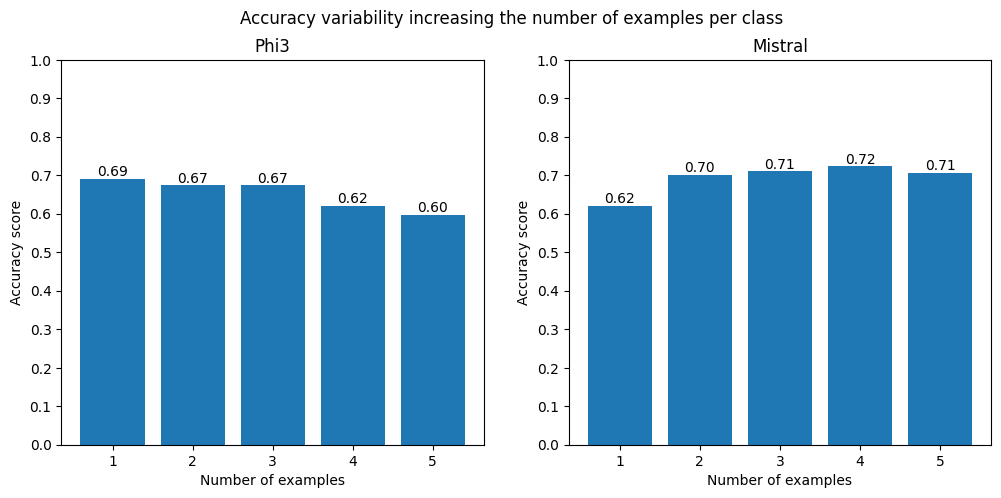

In [ ]:
n_experiments = 5
num_per_class_list= list(range(1, n_experiments+1))

plot_variability(mode= 'quantity', num_per_class= num_per_class_list)

# Experiments

## CoT
We decide to explore the Chain of Thought technique. Our objective is to guide the model reasoning trying to increase its performances.
We try this technique for both Phi3 and Mistral v3.

We add some instruction in the prompt template, giving some general reasoning tools to classify the sentences. Due to the high variability related to the examples found out in the previous section, we decide to not give the model specific examples with explanation, but just some general rules.

In [ ]:
prompt_cot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.
        Think step by step. A sentence is more likely to contain sexism when:
        A woman is associated to an object; a person is discriminated on the basis of its sex; a person, especially a woman, is denigrated due to sexual
        comments.
        TEXT:
        {text}

        ANSWER:
        """
    }
]

 In the following sections we introduce the `full_pipeline` function which avoids multiple repetitions of the same code.

In [ ]:
def full_pipeline(prompt : str, prompting_technique_name : str, performances : dict) -> dict:

    """
    Implements the full pipeline from the preparation of the prompts to the metrics saving.

    Input:
    prompt: the type of prompt
    prompting_technique_name: the name of the prompting technique
    performances: dictionary in which store the computed metrics
    """
    for model, tokenizer in zip((model_1, model_2), (tokenizer_1, tokenizer_2)):

        model_name = 'Phi3' if model == model_1 else 'Mistral'

        if prompting_technique_name == 'few_shot':
            data_loader = prepare_prompts_few_shot(test_data, prompt, tokenizer, num_per_class = 2)
        else:
            data_loader = prepare_prompts(test_data, prompt, tokenizer)

        model_response = generate_responses(model, data_loader)
        model_response = tokenizer.batch_decode(model_response, skip_special_tokens=True)
        model_response = [extract_response(item) for item in model_response]

        performances[f'{model_name}_{prompting_technique_name}'] = compute_metrics(model_response, ground_truth)

    return performances

In [ ]:
performances = full_pipeline(prompt_cot, 'CoT', {})

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

<|system|>
You are an annotator for sexism detection.<|end|>
<|user|>
Your task is to classify input text as containing sexism or not. Respond only YES or NO.
        Think step by step. A sentence is more likely to contain sexism when:
        A woman is associated to an object; a person is discriminated on the basis of its sex; a person, especially a woman, is denigrated due to sexual
        comments.
        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        <|end|>
<|assistant|>



Generating responses: 100%|██████████| 300/300 [02:32<00:00,  1.97it/s]


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.
        Think step by step. A sentence is more likely to contain sexism when:
        A woman is associated to an object; a person is discriminated on the basis of its sex; a person, especially a woman, is denigrated due to sexual
        comments.
        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


Generating responses: 100%|██████████| 300/300 [04:33<00:00,  1.10it/s]


In [ ]:
show_performances_table(performances, save_file= True, file_name= 'CoT_results')

╒═════════════╤══════════════════╤══════════════╤════════════╕
│             │   accuracy_score │   fail_ratio │   f1-score │
╞═════════════╪══════════════════╪══════════════╪════════════╡
│ Phi3_CoT    │            0.73  │            0 │      0.723 │
├─────────────┼──────────────────┼──────────────┼────────────┤
│ Mistral_CoT │            0.647 │            0 │      0.608 │
╘═════════════╧══════════════════╧══════════════╧════════════╛


Phi3 exhibits a more substantial performance boost with this technique, achieving results that even surpass its few-shot performance. In contrast, Mistral does not exhibit similar improvements, as its performance remains lower than that of its few-shot implementation. Specifically, when randomly selecting different examples per class in the few-shot setup, Mistral achieves an average accuracy of 0.7, which it fails to exceed with the current approach.

## A1 dataset

In this subsection, our goal is to evaluate the two models using the dataset provided in Assignment 1. To achieve this, we use the test set to query the models while utilizing the training set as the demonstration set for few-shot prompting. The models are evaluated using the three prompting techniques discussed earlier.

In [ ]:
url = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/main/2024-2025/Assignment%201/data/'

test_df = pd.read_json(url + 'test.json').T
train_df = pd.read_json(url + 'training.json').T

We preprocess the dataset as follows:
- we keep only the english tweets
- we remove the emoticons, urls, users mentions and special charcaters

In [ ]:
def determine_label(row: pd.Series) -> str:

    """
    Converts soft labels into hard labels (strings).

    :param row: row of the dataset to convert (pd.Series)

    :return
        - string representing the hard label
    """

    num_yes = row["labels_task1"].count("YES")
    num_no = row["labels_task1"].count("NO")
    if num_yes == num_no:
        return None
    return "YES" if num_yes > num_no else "NO"

def corpus(df: pd.DataFrame, multilingual:bool = False) -> pd.DataFrame:

    """
    Converts soft labels into hard labels (int) and drops irrelevant rows/columns.

    Input:
    df: dataset split to convert (pd.DataFrame)
    multilingual: whether to keep spanish tweets (bool)

    Output:
        - refined dataset
    """

    df["hard_label_task1"] = df.apply(determine_label, axis=1)
    df = df.dropna(subset=["hard_label_task1"])
    if not multilingual:
      df = df[df["lang"] != "es"]
    df = df[["id_EXIST", "lang", "tweet", "hard_label_task1"]]
    df.loc[df["hard_label_task1"] == "YES", "hard_label_task1"] = 1
    df.loc[df["hard_label_task1"] == "NO", "hard_label_task1"] = 0
    df.reset_index(drop=True, inplace=True)
    return df

test_df = corpus(test_df)
train_df = corpus(train_df)

In [ ]:
url = 'https://raw.githubusercontent.com/muan/unicode-emoji-json/main/data-by-emoji.json'
response = requests.get(url)
json_data = response.json()


emoji_list = list(json_data.keys())
regex_pattern = "|".join(re.escape(word) for word in emoji_list)
regex = re.compile(regex_pattern)

In [ ]:
def data_cleaning(tweet: str) -> str:
    tweet = re.sub(regex.pattern,' ',tweet)
    tweet = re.sub(r'\B\@(\w)+',' ',tweet)
    #tweet = re.sub(r'\B\#(\w)+',' ',tweet)
    tweet = re.sub(r'https?://\S*', ' ', tweet)
    tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)
    tweet = tweet.lower()
    return tweet

test_df['tweet'] = test_df['tweet'].apply(data_cleaning)
train_df['tweet'] = train_df['tweet'].apply(data_cleaning)

In [ ]:
test_df = test_df.rename(columns={'tweet' : 'text', 'hard_label_task1' : 'label_sexist'})
train_df = train_df.rename(columns={'tweet' : 'text', 'hard_label_task1' : 'label_sexist'})
test_df.head()

,id_EXIST,lang,text,label_sexist
0,400178,en,st day at the pool on a beautiful sunday in n...,0
1,400179,en,i like your outfit too except when i dress up...,1
2,400180,en,same though the angst just comes and ...,0
3,400181,en,fuck that cunt tried to vote her out mult...,1
4,400182,en,u gotta say some shit like i ll fuck that c...,1


In [ ]:
train_df['label_sexist'] = train_df['label_sexist'].map(lambda x : 'YES' if x == 1 else 'NO')

In [ ]:
test_data = Dataset.from_pandas(test_df)
ground_truth = np.array(test_data['label_sexist'])
metrics = {'zero_shot' : [], 'few_shot' : [], 'CoT' : []}

### Zero shot prompting

In [ ]:
performances = full_pipeline(zero_shot_prompt, 'zero_shot', {})

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

<|system|>
You are an annotator for sexism detection.<|end|>
<|user|>
Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
         st day at the pool on a beautiful sunday in ny  too bad few dared to go in due to the frigid water temp  we lasted    min and figured we proved our point     

        ANSWER:
        <|end|>
<|assistant|>



Generating responses: 100%|██████████| 286/286 [02:11<00:00,  2.18it/s]


Map:   0%|          | 0/286 [00:00<?, ? examples/s]

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
         st day at the pool on a beautiful sunday in ny  too bad few dared to go in due to the frigid water temp  we lasted    min and figured we proved our point     

        ANSWER:
        [/INST]


Generating responses: 100%|██████████| 286/286 [03:36<00:00,  1.32it/s]


### Few Shot prompting

In [ ]:
performances = full_pipeline(few_shot_prompt, 'few_shot', performances)

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

<|system|>
You are an annotator for sexism detection.<|end|>
<|user|>
Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: So you are mainly attracted to Asian women who have white fever and 10 ex white boyfriends?
ANSWER: YES
TEXT: Now dat rubber rounds are badass they will mame dat shithead for life possibly make him / her disabled
ANSWER: NO
TEXT: No way that dumb bitch could put a sentence like that together... Someone else wrote it, she memorized it...
ANSWER: YES
TEXT: Yep, in modern America when you molest little boys, you get a more lenient sentence (none) than stating verifiable facts about the holocaust in most of Europe. This is so something to celebrate. 👏. 👏. 👏.
ANSWER: NO

        TEXT:
         st day at the pool on a beautiful sunday in ny  too bad few dared to go in due to the frigid water temp  we lasted    min and figured we proved our point     

        ANSWER:
        <|end|>
<|assistant|>



Generating responses: 100%|██████████| 286/286 [03:18<00:00,  1.44it/s]


Map:   0%|          | 0/286 [00:00<?, ? examples/s]

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: The SMF Social media female. Everything this type of female does is for her social media.
ANSWER: YES
TEXT: ROFLMAO.... She's a little thing so ducking to her level is ill advised
ANSWER: NO
TEXT: Yeah with Mgtow Day approaching (Feb 14) I already women being childish, it'll create a surge for sure.
ANSWER: YES
TEXT: Don't mess with granny!
ANSWER: NO

        TEXT:
         st day at the pool on a beautiful sunday in ny  too bad few dared to go in due to the frigid water temp  we lasted    min and figured we proved our point     

        ANSWER:
        [/INST]


Generating responses: 100%|██████████| 286/286 [06:37<00:00,  1.39s/it]


### Chain of Thought prompting

In [ ]:
performances = full_pipeline(prompt_cot, 'CoT', performances)

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

<|system|>
You are an annotator for sexism detection.<|end|>
<|user|>
Your task is to classify input text as containing sexism or not. Respond only YES or NO.
        Think step by step. A sentence is more likely to contain sexism when:
        A woman is associated to an object; a person is discriminated on the basis of its sex; a person, especially a woman, is denigrated due to sexual
        comments.
        TEXT:
         st day at the pool on a beautiful sunday in ny  too bad few dared to go in due to the frigid water temp  we lasted    min and figured we proved our point     

        ANSWER:
        <|end|>
<|assistant|>



Generating responses: 100%|██████████| 286/286 [02:25<00:00,  1.96it/s]


Map:   0%|          | 0/286 [00:00<?, ? examples/s]

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.
        Think step by step. A sentence is more likely to contain sexism when:
        A woman is associated to an object; a person is discriminated on the basis of its sex; a person, especially a woman, is denigrated due to sexual
        comments.
        TEXT:
         st day at the pool on a beautiful sunday in ny  too bad few dared to go in due to the frigid water temp  we lasted    min and figured we proved our point     

        ANSWER:
        [/INST]


Generating responses: 100%|██████████| 286/286 [04:08<00:00,  1.15it/s]


### Results

In [ ]:
show_performances_table(performances, save_file= True, file_name= 'Results_A1_assignment')

╒═══════════════════╤══════════════════╤══════════════╤════════════╕
│                   │   accuracy_score │   fail_ratio │   f1-score │
╞═══════════════════╪══════════════════╪══════════════╪════════════╡
│ Phi3_zero_shot    │            0.72  │            0 │      0.721 │
├───────────────────┼──────────────────┼──────────────┼────────────┤
│ Mistral_zero_shot │            0.759 │            0 │      0.757 │
├───────────────────┼──────────────────┼──────────────┼────────────┤
│ Phi3_few_shot     │            0.699 │            0 │      0.684 │
├───────────────────┼──────────────────┼──────────────┼────────────┤
│ Mistral_few_shot  │            0.801 │            0 │      0.799 │
├───────────────────┼──────────────────┼──────────────┼────────────┤
│ Phi3_CoT          │            0.766 │            0 │      0.765 │
├───────────────────┼──────────────────┼──────────────┼────────────┤
│ Mistral_CoT       │            0.79  │            0 │      0.791 │
╘═══════════════════╧═════════════

The **Mistral_few_shot** model achieves the highest accuracy at 0.801, outperforming all other models.
The Phi3_few_shot model has the lowest accuracy at 0.699, suggesting that it may be less effective for the task when compared to Mistral-based models.
Models that involve zero-shot or CoT techniques (e.g., Phi3_zero_shot and Mistral_CoT) show accuracy in the mid-range, with Mistral-based models generally outperforming Phi3-based ones.

All models report a fail ratio of 0, meaning no model experienced failure during the task. This is an important indicator that the models are stable and did not encounter issues like errors or incomplete predictions during evaluation.

The Mistral-based models (both zero_shot, few_shot, and CoT) tend to outperform the Phi3-based models across all three metrics (accuracy, fail ratio, f1-score).
Few-shot learning appears to provide the best performance across the board, suggesting that the few-shot approach is particularly effective for these tasks.

# [Task 7 - 1.0 points] Report







Wrap up your experiment in a short report (up to 2 pages).

### Instructions







* Use the NLP course report template.



* Summarize each task in the report following the provided template.

### Recommendations







The report is not a copy-paste of graphs, tables, and command outputs.







* Summarize classification performance in Table format.



* **Do not** report command outputs or screenshots.



* Report learning curves in Figure format.



* The error analysis section should summarize your findings.

# Submission







* **Submit** your report in PDF format.



* **Submit** your python notebook.



* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ







Please check this frequently asked questions before contacting us.

### Model cards







You can pick any open-source model card you like.







We recommend starting from those reported in this assignment.

### Implementation







Everything can be done via ``transformers`` APIs.







However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points







0.5 bonus points are arbitrarily assigned based on significant contributions such as:







- Outstanding error analysis



- Masterclass code organization



- Suitable extensions



- Evaluate A1 dataset and perform comparison







Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template







Do not change the provided prompt template.







You are only allowed to change it in case of a possible extension.

### Optimizations







Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End